# Baseline Modelling

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer

from sentence_transformers import SentenceTransformer


In [2]:
path = "/Users/saideepbunny/Projects/Application_Ranking_System"

## Reading the data

In [3]:
df = pd.read_csv(f"{path}/data/synthetic_data/synthetic_data_v2/synthetic_data_v2.csv")
df

,job_data,resume_data,label
0,Audit Manager\nMenzies LLP\nWe are looking for...,**Jennifer Oneal**\n*+1 (555) 555-5555* *|* *j...,Complete Mismatch
1,Audit Manager\nMenzies LLP\nWe are looking for...,**Christina Padilla DVM**\n\n*Email: christina...,Underwhelming
2,Audit Manager\nMenzies LLP\nWe are looking for...,**Andrew Kirby**\n*+44 00000 000000* *|* *andr...,Good Fit
3,Audit Manager\nMenzies LLP\nWe are looking for...,**Erin Hicks**\n*+1 (555) 555-5555* *|* *erin....,Overqualified
4,"Audit Manager\nOverview\nBaker Tilly US, LLP (...",**Randy Smith**\n*+1 (123) 456-7890* *|* *rand...,Complete Mismatch
...,...,...,...
3995,Test Engineer\nJob Summary:\nPerforms LAT test...,# Darren Roberts\n\n*Email*: darren.roberts@em...,Overqualified
3996,Test Engineer\nCompany Description\nMUST be au...,**Lisa Wright**\n*+1 (111) 111-1111* *|* *lisa...,Complete Mismatch
3997,Test Engineer\nCompany Description\nMUST be au...,"# Daniel Meza\n\n*Greensboro, NC* *·* *(555) 5...",Underwhelming
3998,Test Engineer\nCompany Description\nMUST be au...,"# William Torres\n\n*Greensboro, NC* *|* *will...",Good Fit


In [4]:
print("Number of rows in the dataset:", df.shape[0])
print("Number of columns in the dataset:", df.shape[1])

Number of rows in the dataset: 4000
Number of columns in the dataset: 3


In [5]:
df['label'].value_counts()

label
Complete Mismatch    1000
Underwhelming        1000
Good Fit             1000
Overqualified        1000
Name: count, dtype: int64

## Data preprocessing

In [6]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add("overqualified")
stop_words.add("underqualified")
stop_words.add("mismatch")
stop_words.add("good")
print(stop_words)

{'that', 'has', 'now', 'because', 'himself', 'o', "i'm", 'under', "weren't", "won't", 'they', 'with', 'through', 'do', 'some', 't', 'so', 'didn', 'to', 'an', 'above', 'aren', 'was', 'hers', "haven't", 'and', 'm', "don't", 'our', 'until', 'we', 'where', "we've", 'on', 'itself', 'won', 'myself', "couldn't", 'how', "wasn't", "didn't", 'up', "we're", 'shan', "we'd", 'when', 'can', 'between', 'have', 'underqualified', 'whom', 'her', 'against', 'most', 'be', "you'll", 'is', 'him', "they'd", 'ourselves', 'will', 'down', 'his', 'them', 'were', 'haven', 'a', 'than', 's', "that'll", 'the', 'which', 'y', 'yours', 'did', 'it', 'hadn', 'then', "he'll", "we'll", 'again', 'at', "shan't", "she'll", 'below', 'no', 'good', 'having', 're', 'your', 'in', 'yourselves', "it'd", 'there', 'why', 'are', "you're", 'its', "isn't", 'mismatch', 'she', 'while', 'ours', 'about', 'few', "they'll", 'herself', 'any', 'weren', 'd', 'themselves', 'doing', "aren't", 'only', 'all', 'what', "i'd", 'you', 'am', "she's", 'my'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saideepbunny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove unwanted symbols except %, $, /, and .
    text = re.sub(r"[^a-z0-9\s%$/.-]", "", text)

    # Preserve hyphens only when followed by a number (e.g., 2005-2010, 2010-present)
    text = re.sub(r"-(?!\d)", "", text)  # Remove hyphens not followed by a digit

    # Preserve GPA-like formats (e.g., 3.8/4.0)
    text = re.sub(r"(?<!\d)/|/(?!\d)", " ", text)  # Remove '/' unless between numbers

    # Remove periods (".") if they are immediately after a word but not numbers (e.g., "good." → "good", but keep 3.8)
    text = re.sub(r"\b(\w+)\.(?!\d)", r"\1", text)

    # Remove newline characters
    text = text.replace("\n", " ").replace("\r", " ")

    # Remove any show less and show more texts
    text = text.replace("show less", "").replace("show more", "")
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    text = " ".join(word for word in text.split() if word not in stop_words)

    return text

In [8]:
df['job_data_preprocessed'] = df['job_data'].apply(preprocess_text)
df['resume_data_preprocessed'] = df['resume_data'].apply(preprocess_text)

In [9]:
print(df.iloc[1]['job_data'])
print("\n******************************************************\n")
print(df.iloc[1]['job_data_preprocessed'])

Audit Manager
Menzies LLP
We are looking for an experienced
Audit Manager
to join our growing
Audit & Assurance
department in our
Stevenage Office.
This is a role for an ambitious candidate who embraces our core values, whilst supporting the audit partners, helping our clients achieve their aspirations and developing our audit team.
We have a hybrid working policy, career sponsor, excellent support, and personal and career development opportunities.
Why Join Menzies?
We are a UK based recognised employer of choice with office locations in London, Surrey, Hampshire, and South Wales (Cardiff).
Join our family of 500 employees. Be a member and not just a number!
We offer a dynamic and rewarding environment with exposure to a diverse range of clients and industry sectors.
Our package and benefits are very competitive.
Work life balance is part of our organisational culture,
We believe in developing our staff throughout their career.
Key Duties & Responsibilities
Management of an audit focu

In [10]:
print(df.iloc[1]['resume_data'])
print("\n******************************************************\n")
print(df.iloc[1]['resume_data_preprocessed'])

**Christina Padilla DVM**

*Email: christinapadilladmv@email.com* | *Phone: (123) 456-7890* | *LinkedIn: linkedin.com/in/christinapadilladmv*

**Professional Summary**

Highly motivated and dedicated professional with a strong background in financial management and auditing, seeking to transition into an Audit Manager role. Demonstrated experience in managing financial statements, conducting audits, and leading teams. Proficient in FRS102 and IFRS, with a solid understanding of accounting and auditing standards.

**Skills**

*Primary Skills*: Financial Management, Auditing, Team Leadership, Communication, Relationship Building

*Technical Competencies*: FRS102, IFRS, Financial Statements, Accounting Standards, Auditing Standards, Client Meetings, Project Management, Stakeholder Management, Technical Knowledge, Research, Problem Solving

*Complementary Abilities*: Organizational Skills, Time Management, Budgeting, Business Development, Mentoring, Training

**Work Experience**

*Financia

## Modelling: Sentence Embeddings

### Utility functions

In [11]:
def cross_validation_scores(model, X, y, n_splits=5):
    # Define k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    
    # Print results
    print(f"Cross-validation scores: {scores}")
    print(f"Mean accuracy: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    
    
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    Displays a confusion matrix using seaborn heatmap.

    Parameters:
    y_true : list or array
        True labels.
    y_pred : list or array
        Predicted labels.
    labels : list, optional
        Class labels for the confusion matrix.
    title : str, optional
        Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()


def chunk_text(text, max_length=512, overlap=50):
    """
    Splits text into overlapping chunks.
    """
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_length - overlap):
        chunk = " ".join(words[i:i+max_length])
        chunks.append(chunk)
        if i + max_length >= len(words):
            break
    return chunks

def get_text_embedding(text, model):
    """
    Converts large text into embeddings using chunking + mean pooling.
    """
    chunks = chunk_text(text)
    embeddings = model.encode(chunks, convert_to_numpy=True)  # Get embeddings
    return np.mean(embeddings, axis=0)  # Aggregate embeddings using mean pooling

### Generating embeddings

In [12]:
embedding_df = pd.DataFrame()

# Load a Transformer model
embedding_model = SentenceTransformer('all-mpnet-base-v2') #768 dimension vector space


In [13]:
# Compute embeddings
overall_data = "Job Description:\n" + df['job_data_preprocessed'] + "\nResume:\n" + df['resume_data_preprocessed'] 
overall_d1 = overall_data.apply(lambda x: get_text_embedding(x, embedding_model))

embedding_df = pd.DataFrame(overall_d1.tolist(), index=df.index, columns = [f"f_{i+1}" for i in range(len(overall_d1.tolist()[0]))])
embedding_df

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_759,f_760,f_761,f_762,f_763,f_764,f_765,f_766,f_767,f_768
0,0.039902,0.019237,3.259629e-07,0.005269,-0.005995,0.022996,-0.020843,0.038934,-0.045135,-0.052423,...,0.004539,-0.016708,-0.007673,0.048415,-0.037936,-0.033232,0.032828,0.004612,0.016106,-0.016075
1,0.033731,0.014575,-1.989282e-03,0.001785,-0.006413,0.027760,-0.030911,0.041761,-0.042073,-0.043781,...,-0.003496,-0.017285,-0.028689,0.062904,-0.032291,-0.030862,0.046561,0.005631,0.025243,-0.011054
2,0.032892,0.013800,3.890766e-03,0.003200,-0.017978,0.023132,-0.029153,0.044440,-0.042092,-0.054451,...,-0.003161,-0.019347,-0.020028,0.058405,-0.027469,-0.035354,0.044262,0.005733,0.033439,-0.012772
3,0.033019,0.014608,-9.375568e-04,0.002512,-0.012864,0.027180,-0.033369,0.044740,-0.039306,-0.049283,...,-0.003470,-0.019564,-0.019259,0.062359,-0.029758,-0.030552,0.041913,0.006736,0.028268,-0.014451
4,0.044420,0.040932,-2.001518e-02,0.004388,0.007145,0.024370,-0.032387,0.031219,-0.015131,-0.041179,...,-0.023790,0.034369,-0.066056,0.075000,-0.023851,-0.032413,0.012431,-0.022404,0.020373,-0.028323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.017596,-0.016783,-4.980309e-02,-0.021874,0.006161,0.009479,0.060287,0.027132,-0.001314,-0.017136,...,0.009589,0.005898,-0.003005,0.019375,-0.050704,0.031338,-0.019991,-0.011120,-0.013836,-0.036627
3996,0.013627,-0.000653,-3.760924e-02,-0.009146,-0.013077,-0.003855,-0.006985,0.037001,0.003450,-0.058174,...,-0.012531,0.014639,0.019925,0.022123,-0.023571,-0.003405,-0.033593,-0.011541,0.027266,-0.023856
3997,0.025036,-0.016127,-4.624021e-02,-0.012599,0.023608,-0.001605,0.033035,0.004007,-0.009291,-0.077884,...,-0.016660,0.019386,0.046822,0.008919,-0.005116,0.025305,-0.023257,-0.021600,0.006096,-0.037539
3998,0.002439,-0.027380,-4.248336e-02,-0.004193,0.021859,0.002401,0.037243,0.029400,-0.029422,-0.069642,...,-0.008167,0.021736,0.030660,0.012810,-0.006992,0.029361,-0.022041,-0.024703,0.002900,-0.028889


### Defining X and y

In [14]:
# Stack embeddings horizontally
X = embedding_df.copy()
y = df['label']

### Train Test split

In [15]:
# Assuming X contains features and y contains labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (3200, 768)
Test data shape:  (800, 768)


### DecisionTreeClassifier

In [16]:
model_4class = DecisionTreeClassifier(random_state=42)  # Example model
cross_validation_scores(model_4class, X_train, y_train, n_splits=5)

Cross-validation scores: [0.36875   0.3765625 0.3703125 0.4109375 0.403125 ]
Mean accuracy: 0.3859
Standard deviation: 0.0176


In [17]:
# Train model on full training set
model_4class.fit(X_train, y_train)

# Evaluate on test set
y_pred = model_4class.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Complete Mismatch       0.61      0.57      0.59       200
         Good Fit       0.26      0.30      0.28       200
    Overqualified       0.31      0.29      0.30       200
    Underwhelming       0.36      0.35      0.36       200

         accuracy                           0.38       800
        macro avg       0.39      0.38      0.38       800
     weighted avg       0.39      0.38      0.38       800


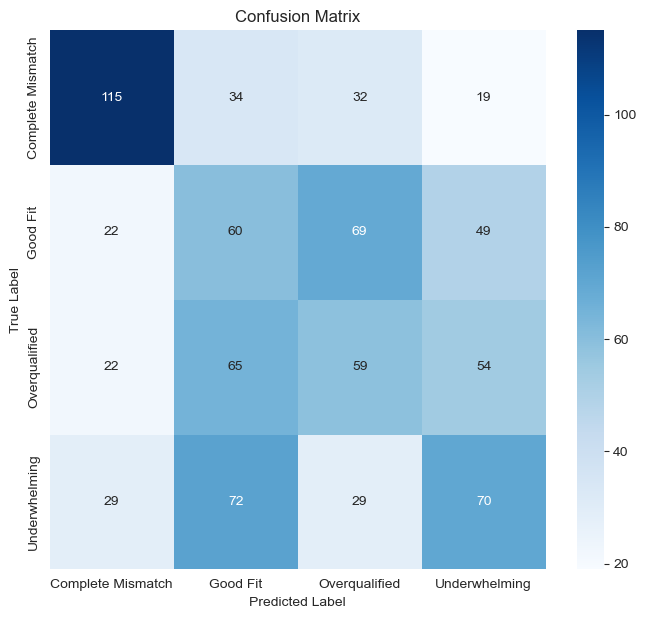

In [18]:
plot_confusion_matrix(y_test, y_pred, ["Complete Mismatch", "Good Fit", "Overqualified", "Underwhelming"])

### RandomForestClassifier

In [19]:
model_4class = RandomForestClassifier(random_state=42)  # Example model
cross_validation_scores(model_4class, X_train, y_train, n_splits=5)

Cross-validation scores: [0.4453125 0.4484375 0.4359375 0.465625  0.4390625]
Mean accuracy: 0.4469
Standard deviation: 0.0104


In [20]:
# Train model on full training set
model_4class.fit(X_train, y_train)

# Evaluate on test set
y_pred = model_4class.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Complete Mismatch       0.87      0.86      0.86       200
         Good Fit       0.24      0.27      0.25       200
    Overqualified       0.39      0.37      0.38       200
    Underwhelming       0.42      0.40      0.41       200

         accuracy                           0.47       800
        macro avg       0.48      0.47      0.48       800
     weighted avg       0.48      0.47      0.48       800


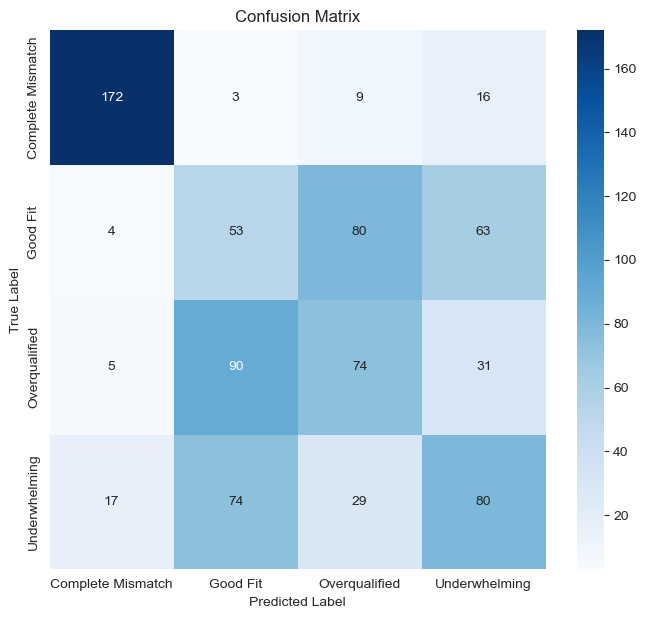

In [21]:
plot_confusion_matrix(y_test, y_pred, ["Complete Mismatch", "Good Fit", "Overqualified", "Underwhelming"])

### XGBClassifier : Multi class classification

In [22]:
X = embedding_df.copy()
y = df['label'].replace({"Complete Mismatch": 0, "Underwhelming":1, "Good Fit":2, "Overqualified":3})

/var/folders/t5/tflj5hjs197_vv37fw2sdhdr0000gn/T/ipykernel_86690/3337498069.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['label'].replace({"Complete Mismatch": 0, "Underwhelming":1, "Good Fit":2, "Overqualified":3})


In [23]:
# Assuming X contains features and y contains labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (3200, 768)
Test data shape:  (800, 768)


In [24]:
xgb_4class = XGBClassifier(random_state=42)  # Example model
cross_validation_scores(xgb_4class, X_train, y_train, n_splits=5)

Cross-validation scores: [0.5703125 0.5890625 0.546875  0.56875   0.534375 ]
Mean accuracy: 0.5619
Standard deviation: 0.0192


In [25]:
# Train model on full training set
xgb_4class.fit(X_train, y_train)

# Evaluate on test set
y_pred = xgb_4class.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       200
           1       0.63      0.62      0.63       200
           2       0.38      0.43      0.41       200
           3       0.50      0.52      0.51       200

    accuracy                           0.60       800
   macro avg       0.62      0.60      0.61       800
weighted avg       0.62      0.60      0.61       800


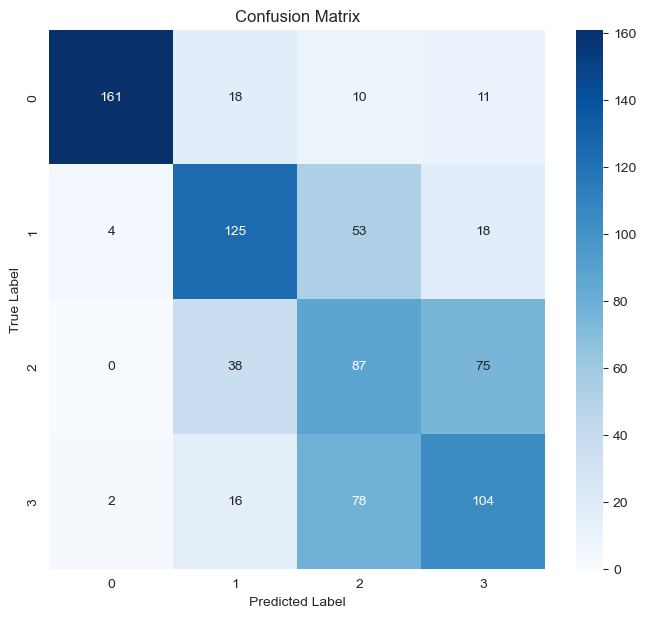

In [26]:
plot_confusion_matrix(y_test, y_pred, [0, 1, 2, 3])

### XGBClassifier : Binary Classification

- Complete Mismatch and Underwhelming are bad fits (0)
- Good fit and Overqualified are good fits (1)

In [27]:
X = embedding_df.copy()
y = df['label'].replace({"Complete Mismatch": 0, "Underwhelming":0, "Good Fit":1, "Overqualified":1})

/var/folders/t5/tflj5hjs197_vv37fw2sdhdr0000gn/T/ipykernel_86690/2897412205.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['label'].replace({"Complete Mismatch": 0, "Underwhelming":0, "Good Fit":1, "Overqualified":1})


In [28]:
# Assuming X contains features and y contains labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (3200, 768)
Test data shape:  (800, 768)


In [29]:
xgb_2class = XGBClassifier(random_state=42)  # Example model
cross_validation_scores(xgb_2class, X_train, y_train, n_splits=5)

Cross-validation scores: [0.765625  0.7875    0.7953125 0.8125    0.8140625]
Mean accuracy: 0.7950
Standard deviation: 0.0178


In [30]:
# Train model on full training set
xgb_2class.fit(X_train, y_train)

# Evaluate on test set
y_pred = xgb_2class.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       400
           1       0.78      0.85      0.81       400

    accuracy                           0.80       800
   macro avg       0.81      0.80      0.80       800
weighted avg       0.81      0.80      0.80       800


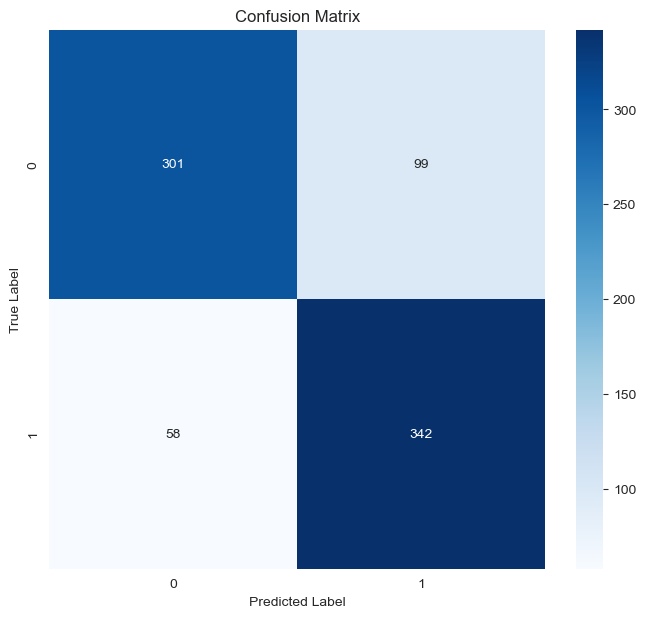

In [31]:
plot_confusion_matrix(y_test, y_pred, [0, 1])

In [32]:
rd="""
A Data Scientist with 3 years of experience in developing machine learning pipelines and models to address business needs. Also
experienced in communicating insights to enhance strategic decision-making and improve performance outcomes.
EDUCATION
Master Of Science In Data Science
Northeastern University | GPA: 3.93 / 4.00 Portland, Maine | Sep 2023
- May 2025
Bachelor Of Technology In Computer Science
Vardhaman College of Engineering | GPA: 8.84 / 10.00 Hyderabad | May 2017
- Jun 2021
WORK EXPERIENCE
Data Engineer Co-Op | Full-time Jul 2024
- Present
EAI at Northeastern University
• Engineered an end-to-end claim complexity scoring ML pipeline for MEMIC, negating ~3 minutes of mannual classification per claim.
• Developed a robust claim complexity scoring model and reduced false negatives by 20%, streamlining the Claim Assignment Engine's efficiency within 6 months.
• Identified an issue with prediction validation, which led to employing advanced testing validated by statistical tests.
• Revised the existing claim assignment process to automatically assign claims classified by scoring engine to agents by prioritizing highly complex claims, achieving 100% automation.
• Communicated weekly insights to clients, enhancing strategic decision-making and improving performance outcomes through
experimental findings and suggesting actionable plans.
Azure Data Engineer | Full-time Aug 2021
- Jul 2023
LTIMindtree
• Resolved customer issues from Azure cloud services with an average solution acceptance rate of 50%, consistently for over one year.
• Utilized Azure Databricks data engineering environment to solve business problems for customers and improve data quality by 35%.
• Automated ETL pipelines for big data extraction and processing using Data factory and Dataflows, reducing processing time by 40%.
• Recognized as a highly motivated member of Azure Collective on Stack Overflow, contributing 404 answers and reaching 428k people.
• Developed a Question Moderator Model that improved question validation efficiency, saving 10% of time monthly by minimizing
invalid question engagement.
PROJECTS
Application Ranking System Sep 2024
- Apr 2025
• Built an AI-powered Application Ranking System using cosine similarity, FAISS, and a custom scoring formula for efficient ranking.
Aims to improve hiring by reducing bias, rewarding well-crafted resumes, and offering a fair ranking system for job applications.
Stance Detection Model Using Generative AI
• Developed a Huggingface space using fine-tuned text classification LLM to detect the stance using manually labeled and synthetic data.
Leveraged LoRA fine-tuning to train only ~1% of LLM's parameters in Roberta base model's architecture to achieve 0.80 accuracy.

SKILLS
Programming: Python, SQL Server, Java, Data Structures and Algorithms, Problem-
solving skills
Machine Learning: Machine Learning, Regression, Classification, Data Cleaning, Data preprocessing, Data transformation, Feature
Engineering, Data Visualization, XGBoost, Cross Validation, Deep learning, Neural Networks, Natural Language Processing, Transformers,
Sentiment Analysis, Huggingface, Large Language models, Fine tuning, Prompt Engineering, Generative AI, RAG, Agentic AI
Libraries: NumPy, Pandas, Matplotlib, Scikit-
Learn, xgboost, SciPy, spaCy, Pytorch, Tensorflow, Optuna, Langchain, ollama, transformers
Others: Jupyter, Azure, Git, SSMS, PowerBI, Microsoft Excel, Databricks, PySpark, Documentation, Statistical analysis
"""

jd="""
Construction project engineer
JARDINE is a premier construction management and general contracting firm based in Centerville, Utah. We specialize in commercial construction with a focus on historic renovations, mountain and resort construction, light industrial projects, pharmaceutical and nutraceutical facilities, clean rooms, lab spaces, retail environments, food & beverage spaces, and tenant improvements. Our approach prioritizes collaborative project delivery methods such as Construction Management/General Contracting, Design-Build, Design Assist, and Cost-Plus to ensure successful project outcomes.

Role Description
JARDINE is seeking a full-time, on-site Construction Project Engineer to join our team in the Salt Lake City Metropolitan Area. This role is instrumental in supporting project execution, ensuring smooth coordination between field teams, subcontractors, and project management. The Construction Project Engineer will be actively involved in project coordination, construction engineering, RFI's, submittals, and communication to drive project success.

Key Responsibilities
Project Coordination: Support project managers and field teams in scheduling, logistics, and workflow efficiency.
Construction Engineering: Assist in design reviews, constructability analysis, and technical problem-solving.
Quality Control: Ensure compliance with project specifications, safety standards, and best practices.
Submittals & RFIs: Prepare, track, and manage submittals, RFIs, and change orders throughout the project lifecycle.
Communication: Maintain clear and effective communication between project stakeholders, including subcontractors, suppliers, and clients.
Documentation & Reporting: Keep detailed records of project progress, budgets, and schedules using construction management software.
Qualifications
Strong project coordination and construction engineering skills.
Experience in RFI and submittal processes.
Excellent written and verbal communication skills.
Proficiency in construction project management software (e.g., Procore, Bluebeam, MS Project).
Ability to read and interpret construction drawings and specifications.
Bachelor’s degree in Construction Management, Civil Engineering, or a related field.
Relevant certifications such as PE (Professional Engineer) or PMP (Project Management Professional) are a plus.
Why Join JARDINE?
Competitive salary based on experience.
Health benefits, 401(k), and paid time off.
Opportunities for career growth and professional development.
A collaborative, team-oriented work environment.

Project Coordination, Construction Engineering, RFI Process, Submittals Management, Quality Control, Scheduling, Logistics, Workflow Efficiency, Constructability Analysis, Technical Problem-Solving, Compliance with Safety Standards, Change Order Management, Stakeholder Communication, Documentation, Reporting, Construction Management Software (Procore, Bluebeam, MS Project), Construction Drawings Interpretation, Budget Tracking, Civil Engineering, Construction Management, Project Management, Professional Certifications (PE, PMP).
"""

In [33]:
real_df = pd.DataFrame([{"job_data":jd, "resume_data":rd}])
real_df

,job_data,resume_data
0,\nConstruction project engineer\nJARDINE is a ...,\nA Data Scientist with 3 years of experience ...


In [34]:
real_df['job_data_preprocessed'] = real_df['job_data'].apply(preprocess_text)
real_df['resume_data_preprocessed'] = real_df['resume_data'].apply(preprocess_text)

# Compute embeddings
combined_data = "Job Description:\n" + real_df['job_data_preprocessed'] + "\nResume:\n" + real_df['resume_data_preprocessed'] 
combined_d1 = combined_data.apply(lambda x: get_text_embedding(x, embedding_model))

edf = pd.DataFrame(combined_d1.tolist(), index=real_df.index, columns = [f"f_{i+1}" for i in range(len(combined_d1.tolist()[0]))])
edf

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_759,f_760,f_761,f_762,f_763,f_764,f_765,f_766,f_767,f_768
0,0.02746,0.074395,-0.044027,-0.020334,0.015358,0.010736,-0.013945,0.002697,-0.052822,-0.023759,...,-0.01144,0.003331,-0.016823,0.028028,-0.008,-0.033974,-0.028421,-0.004494,0.002082,-0.03323


### Results

In [35]:
print("Predicted category for 4-category classification: ",xgb_4class.predict(edf))
print("Predicted probabilities for 4-category classification: ",xgb_4class.predict_proba(edf))

Predicted category for 4-category classification:  [3]
Predicted probabilities for 4-category classification:  [[0.07966397 0.29293332 0.261564   0.36583874]]


In [36]:
xgb_4class.predict_proba(edf)

array([[0.07966397, 0.29293332, 0.261564  , 0.36583874]], dtype=float32)

#### Two Class prediction

Expected output is 0 : Bad

In [37]:
print("Predicted category for 2-category classification: ",xgb_2class.predict(edf))
print("Predicted category for 2-category classification: ",xgb_2class.predict_proba(edf))

Predicted category for 2-category classification:  [1]
Predicted category for 2-category classification:  [[0.01601696 0.98398304]]


In [38]:
xgb_2class.predict_proba(edf)

array([[0.01601696, 0.98398304]], dtype=float32)

We can observe that these ML models are unable to generalize on a clear complete mismatch case above. The next step would be to use LLMs to perform the classification and decide whether fine-tuning is required or not.